<h1 style="color:#BF66F2 ">  Feedforward Neural Networks in PyTorch 2 </h1>
<div style="margin-top: -30px;">
<h4> 2 examples based on the "Street View House Numbers" dataset. Focus on learning rate schedulers. </h4>
</div>
<div style="margin-top: -18px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    ReduceLROnPlateau scheduler + make_grid + show image with matplotlib + torch random split
</span>
</div>

In [1]:
# Ignore CUDA warnings when GPU is not in use
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets 
from torchvision.datasets import SVHN

from torchvision.utils import make_grid
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Force PyTorch to use CPU, to avoid CUDA warnings
device = torch.device("cpu") 
device

device(type='cpu')

<h2 style="color:#BF66F2 "><u>Example 1</u></h2>

In [5]:
#### Hyperparameters
num_classes = 10
learning_rate = 0.1
batch_size = 128
num_epochs = 100

In [6]:
model = nn.Sequential(nn.Linear(3072,128), 
                    nn.ReLU(), 
                    nn.Linear(128, 128)).to(device)  #(128x3072 and 784x50) #(128x128 and 50x10)

In [7]:
train_dataset = SVHN(root="./dataset", split='train', transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 182040794/182040794 [01:11<00:00, 2561303.68it/s]


In [9]:
### Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

<h3 style="color:#BF66F2 "><u> Recap: </u></h3>
<div style="margin-top: -20px;">
A learning rate scheduler can improve the convergence and performance by dynamically adjust the learning rate during training.

"ReduceLROnPlateau" is a specific scheduler designed to reduce the learning rate when, during training, the validation loss when stops improving due to plateaus presence.


**Other Available schedulers:** <br>

1) <font color="#BF66F2">StepLR:</font> Adjusts the learning rate by a factor at predefined steps. It's useful for reducing the learning rate at fixed intervals.
- scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

2) <font color="#BF66F2">MultiStepLR:</font> 
Similar to StepLR, but it is possible to specify multiple milestones for learning rate changes.
- scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

3) <font color="#BF66F2">ExponentialLR:</font>
Exponentially reduces the learning rate over time.
- scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

4) <font color="#BF66F2">CosineAnnealingLR:</font>
Schedules the learning rate using a cosine annealing strategy. It's useful for cyclic learning rate schedules.
- scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

5) <font color="#BF66F2">CyclicLR:</font> 
Implements a cyclic learning rate schedule with a triangular or triangular2 shape.
- scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, cycle_momentum=False)

6) <font color="#BF66F2"> LambdaLR:</font> 
Permits the specifation of a custom function to control the learning rate schedule.
- scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

7) <font color="#BF66F2"> OneCycleLR:</font> 
Implements the 1Cycle learning rate policy, which includes both increasing and decreasing learning rates during training.
- scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=1000)


In [10]:
""" Other available optimizers. """
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer_rms = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer_adagrad = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
optimizer_adadelta = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
optimizer_adamw = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [12]:
""" Train. 
After each epoch do "scheduler.step" to send loss for that epoch! 
It can also be set using validation loss in the forward loop, but then is needed to modify the patience parameter.
"""
###################### Train
for epoch in range(1, num_epochs):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.reshape(data.shape[0], -1)
        data = data.to(device=device)
        targets = targets.to(device=device)
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = sum(losses) / len(losses)
    mean_loss = round(mean_loss, 2)         #difference in loss at 2 decimals
    scheduler.step(mean_loss)
    
    if epoch % 10 == 0:
        print(f"The Average loss for epoch {epoch} was {mean_loss}")

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            x = x.reshape(x.shape[0], -1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples)*100:.2f}")

    model.train()

check_accuracy(train_loader, model)

Epoch 00013: reducing learning rate of group 0 to 1.0000e-02.
The Average loss for epoch 10 was 2.24
Epoch 00024: reducing learning rate of group 0 to 1.0000e-03.
The Average loss for epoch 20 was 2.24
Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
The Average loss for epoch 30 was 2.24
The Average loss for epoch 40 was 2.24
Epoch 00046: reducing learning rate of group 0 to 1.0000e-05.
The Average loss for epoch 50 was 2.24
Epoch 00057: reducing learning rate of group 0 to 1.0000e-06.
The Average loss for epoch 60 was 2.24
Epoch 00068: reducing learning rate of group 0 to 1.0000e-07.
The Average loss for epoch 70 was 2.24
Epoch 00079: reducing learning rate of group 0 to 1.0000e-08.
The Average loss for epoch 80 was 2.24
The Average loss for epoch 90 was 2.24
Got 13861 / 73257 with accuracy 18.92


<h2 style="color:#BF66F2 "><u>Example 2</u></h2>

In [2]:
dataset = SVHN(root='data/', download=True, transform=ToTensor())
val_size = 12000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

100%|██████████| 182040794/182040794 [00:17<00:00, 10634722.37it/s]


(61257, 12000)

In [ ]:
""" Create DataLoaders with 4 subprocesses and 'pin_memory' set to True (the loader will copy 
Tensors into device/CUDA pinned memory before returning them).
"""
batch_size = 64 
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([64, 3, 32, 32])


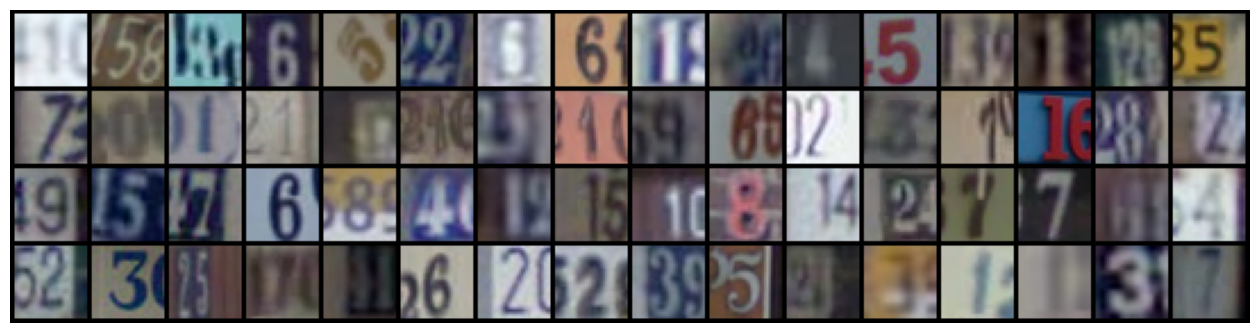

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [49]:
class SvhnModel(nn.Module):
    """ Model of a feedforward neural network with six hidden layers. 
    
        Args:
            - Input size, which is the number of features in the input data [int]
            - Output size, which is the number of classes for classification [int]
    """
    def __init__(self, in_size, out_size):
        super().__init__()
        # Hidden layers
        self.linear1 = nn.Linear(in_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 32)
        # Output layer
        self.linear7 = nn.Linear(32, out_size)
    
    def accuracy(self, outputs, labels):
        """ Calculate accuracy of model predictions.\\
        Find the class with the highest predicted score for each input.\\
        Calculate the number of correct predictions and divide by the total number of predictions.
        
        Parameters:
            - outputs: Model predictions [Tensor]
            - labels: Ground truth labels [Tensor]

        Returns:
            Accuracy [Tensor]
        """        
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def forward(self, xb):
        """ Forward pass through the neural network. """
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        ########### Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear7(out)
        
        return out
    
    def training_step(self, batch):
        """ Perform a training step. """
        images, labels = batch 
        # Generate predictions
        out = self(images)                  
        # Calculate loss
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        """ Perform a validation step. """
        images, labels = batch 
        # Generate predictions
        out = self(images)                    
        print(out)
        # Calculate loss
        loss = F.cross_entropy(out, labels)   
        # Get accuracy
        acc = self.accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        """ Aggregate and summarize validation results at the end of an epoch.

        Parameters:
            outputs: List of dictionaries with validation step results

        Details: 
            - #1 Extract val_losses from the list of validation step results
            - #2 Combine val_losses by taking their mean
            - #3 Extract val_accuracies from the list of validation step results
            - #4 Combine val_accuracies by taking their mean

        Returns:
            Mean validation loss and accuracy [dict]
        """        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [50]:
model = SvhnModel(in_size=32*32*3, out_size=10)

In [51]:
for t in model.parameters():
    print(t.shape)

torch.Size([1024, 3072])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [52]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.319042682647705
outputs.shape :  torch.Size([64, 10])
Sample outputs :
 tensor([[ 0.1440, -0.1424,  0.0472, -0.0241, -0.0035,  0.1067, -0.0234, -0.0347,
          0.0076, -0.0280],
        [ 0.1442, -0.1422,  0.0475, -0.0246, -0.0040,  0.1070, -0.0237, -0.0342,
          0.0082, -0.0278]])


In [53]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [54]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [55]:
for images, labels in train_loader:
    print(images.shape)
    dev = get_default_device()
    images = to_device(images, dev)
    print(images.device)
    break

torch.Size([64, 3, 32, 32])
cpu


In [56]:
class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device. """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """ Yield a batch of data after moving it to device. """
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """ Return number of batches. """
        return len(self.dl)

In [57]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([3, 2, 5, 7, 3, 4, 3, 7, 7, 0, 0, 6, 2, 3, 7, 7, 8, 4, 2, 3, 4, 2, 1, 2,
        5, 0, 5, 0, 1, 4, 3, 0, 8, 2, 4, 1, 4, 6, 5, 1, 1, 3, 5, 0, 1, 8, 2, 2,
        9, 2, 1, 5, 6, 1, 7, 4, 5, 5, 4, 8, 4, 4, 5, 3, 7, 4, 1, 3, 2, 9, 5, 9,
        0, 4, 9, 5, 1, 3, 7, 1, 1, 0, 2, 6, 4, 3, 4, 5, 3, 3, 6, 1, 7, 4, 2, 1,
        2, 2, 8, 1, 5, 3, 7, 4, 6, 4, 1, 2, 2, 5, 9, 5, 4, 0, 9, 3, 9, 8, 3, 8,
        3, 4, 1, 5, 6, 7, 1, 7])


In [58]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ##### Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        ### Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
history = [evaluate(model, val_loader)]
history

tensor([[ 0.1442, -0.1424,  0.0469,  ..., -0.0339,  0.0076, -0.0269],
        [ 0.1441, -0.1424,  0.0470,  ..., -0.0336,  0.0075, -0.0270],
        [ 0.1444, -0.1423,  0.0470,  ..., -0.0344,  0.0077, -0.0274],
        ...,
        [ 0.1445, -0.1423,  0.0471,  ..., -0.0341,  0.0074, -0.0269],
        [ 0.1441, -0.1423,  0.0470,  ..., -0.0340,  0.0077, -0.0276],
        [ 0.1447, -0.1417,  0.0475,  ..., -0.0343,  0.0075, -0.0276]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1443, -0.1418,  0.0473,  ..., -0.0342,  0.0080, -0.0269],
        [ 0.1441, -0.1418,  0.0470,  ..., -0.0345,  0.0075, -0.0265],
        [ 0.1447, -0.1422,  0.0471,  ..., -0.0339,  0.0076, -0.0267],
        ...,
        [ 0.1442, -0.1420,  0.0472,  ..., -0.0337,  0.0071, -0.0274],
        [ 0.1445, -0.1424,  0.0468,  ..., -0.0339,  0.0071, -0.0270],
        [ 0.1441, -0.1417,  0.0473,  ..., -0.0343,  0.0081, -0.0277]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.1441, -0.1418,  0.0471,  ..., -0.0339,  0.0077, -0.027

[{'val_loss': 2.318418025970459, 'val_acc': 0.07022938877344131}]

In [ ]:
""" Train the model passing (training_epochs, learning rate, model, dataloader train, dataloader validation) 
and append the fit's results to the 'history' list.
"""
history += fit(10, 1e-2, model, train_loader, val_loader) 